In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras import optimizers
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import os

C:\Users\Aiman\Anaconda3\envs\sticker\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


In [2]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")

In [6]:
SAVE_DATA_PATH = os.path.join(TRAIN_DATASET_PATH, "singlecoil_train_3D_images_48x/")

In [7]:
x_train = np.load("{}/x_train_3D.npy".format(SAVE_DATA_PATH))
y_train = np.load("{}/y_train_3D.npy".format(SAVE_DATA_PATH))

x_train.shape, y_train.shape

((500, 320, 320, 28), (500, 320, 320, 28))

In [8]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
model=None

In [17]:
inputs = Input((320, 320, 1))
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 320, 320, 16) 160         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_64 (Dropout)            (None, 320, 320, 16) 0           conv2d_134[0][0]                 
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 320, 320, 16) 2320        dropout_64[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [18]:
h = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=300)

Train on 9000 samples, validate on 1000 samples
Epoch 1/300
9000/9000 [==============================] - 419s 47ms/step - loss: 0.0531 - mean_iou: 0.4947 - val_loss: 0.0425 - val_mean_iou: 0.4959
Epoch 2/300
9000/9000 [==============================] - 419s 47ms/step - loss: 0.0394 - mean_iou: 0.4957 - val_loss: 0.0413 - val_mean_iou: 0.4956
Epoch 3/300
9000/9000 [==============================] - 418s 46ms/step - loss: 0.0373 - mean_iou: 0.4955 - val_loss: 0.0383 - val_mean_iou: 0.4955
Epoch 4/300
9000/9000 [==============================] - 415s 46ms/step - loss: 0.0361 - mean_iou: 0.4955 - val_loss: 0.0374 - val_mean_iou: 0.4954
Epoch 5/300
9000/9000 [==============================] - 417s 46ms/step - loss: 0.0355 - mean_iou: 0.4954 - val_loss: 0.0390 - val_mean_iou: 0.4954
Epoch 6/300
9000/9000 [==============================] - 418s 46ms/step - loss: 0.0351 - mean_iou: 0.4953 - val_loss: 0.0363 - val_mean_iou: 0.4953
Epoch 7/300
9000/9000 [==============================] - 417s 46

KeyboardInterrupt: 

In [ ]:
model.save("{}/unet_1.h5".format(PATH_MAIN))

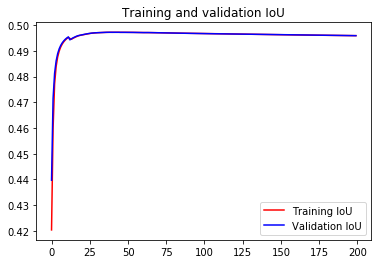

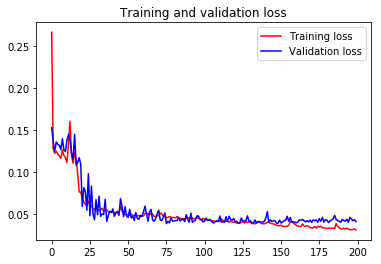

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = h.history['mean_iou']
val_acc = h.history['val_mean_iou']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training IoU')
plt.plot(epochs, val_acc, 'b', label='Validation IoU')
plt.title('Training and validation IoU')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()
